<h1>Importar e instalar dependencias</h1>
<p>Descripción: Paso inicial para importar e instalar todas las dependencias necesarias.</p>

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import time

import cv2
import mediapipe as mp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm


<h1>Puntos clave utilizando MP Holistic</h1>
<p>Descripción: Descripción de cómo utilizar MP Holistic para identificar puntos clave.</p>

CREA FUNCIONES DE DETETECCION Y LAS PRUEBA 

In [2]:
from keras import Sequential
from keras.src.utils import to_categorical
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from tensorboard.program import TensorBoard

mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities



In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False  # Image is no longer writeable
    results = model.process(image)  # Make prediction
    image.flags.writeable = True  # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results):
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp.solutions.face_mesh.FACEMESH_TESSELATION)
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

def draw_styled_landmarks(image, results):
    # Draw face connections
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp.solutions.face_mesh.FACEMESH_TESSELATION,
                                  mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                                  mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))
    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2))
    # Draw left hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2))
    # Draw right hand connections
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

In [4]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        # Draw landmarks
        draw_styled_landmarks(image, results)
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


C:\Users\romel\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [5]:
draw_landmarks(frame, results)

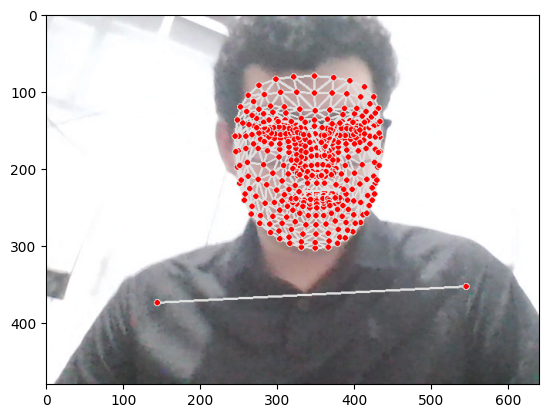

In [6]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


<h1>Extraer valores de puntos clave</h1>
<p>Descripción: Procedimiento para extraer los valores de los puntos clave identificados.</p>

In [7]:

if results.face_landmarks:
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()
else:
    face = np.zeros(1404)

In [8]:

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [9]:
result_test = extract_keypoints(results)
np.save('0', result_test)

In [10]:
loaded_result = np.load('0.npy')
print(loaded_result)


[ 0.56424099  0.38181484 -1.62007368 ...  0.          0.
  0.        ]


<h1>Configurar carpetas para la colección</h1>
<p>Descripción: Instrucciones para organizar y configurar carpetas para la colección de datos.</p>

In [11]:
# ruta de dond exportar datos
DATA_PATH = os.path.join('MP_Data')

# Accion que trata de ddetectar
actions = np.array(['hola', 'te_quiero', 'gracias'])

# comenzar folder
start_folder = 0

In [13]:

DATA_PATH = os.path.join('MP_Data')
actions = np.array(['hola', 'te_quiero', 'gracias'])
# 30 videos de datos
no_sequences = 30

# los videos tinenen tamaño de 30 
sequence_length = 30
# comenzar folder
start_folder = 0

In [14]:

for action in actions:
    dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(1,no_sequences+1):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(dirmax+sequence)))
        except:
            pass


<h1>Recopile valores de puntos clave para capacitación y pruebas</h1>
<p>Descripción: Método para recopilar valores de puntos clave que se usarán en la capacitación y pruebas del modelo.</p>

In [15]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder + no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                # NEW Apply wait logic
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)

                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()
cap.release()
cv2.destroyAllWindows()  


<h1>Preprocesar datos y crear etiquetas y funciones</h1>
<p>Descripción: Pasos para preprocesar los datos y crear etiquetas y funciones necesarias para el entrenamiento del modelo.</p>

In [16]:
from sklearn.model_selection import train_test_split
label_map = {label: num for num, label in enumerate(actions)}


<h3>Carga de los datos y asignación de etiquetas: </h3>   
   <p>itera sobre cada acción en actions.   </p>
    <p>Para cada acción, itera sobre 29 secuencias.</p>
    <p>Para cada secuencia, carga los datos de cada frame desde archivos .npy almacenados en DATA_PATH.</p>
    <p>Almacena cada secuencia de frames en la lista sequences.</p>
    <p>Asigna la etiqueta correspondiente a cada secuencia y la almacena en la lista labels.</p>


<h1>Construya y entrene la red neuronal LSTM</h1>
<p>Descripción: Guía para construir y entrenar una red neuronal LSTM con los datos preprocesados.</p>

In [17]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard, Callback
from tqdm import tqdm
import numpy as np

In [18]:

# Data preparation
DATA_PATH = os.path.join('MP_Data')
actions = np.array(['hola', 'te_quiero', 'gracias'])
no_sequences = 30
sequence_length = 30
label_map = {label: num for num, label in enumerate(actions)}

sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)


In [19]:
# Model creation
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.save('action.keras', include_optimizer=False)


C:\Users\romel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



<h1>Haz predicciones</h1>
<p>Descripción: Instrucciones para hacer predicciones utilizando el modelo entrenado.</p>

In [ ]:
class TQDMProgressCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
            self.epochs = self.params['epochs']
            self.progress_bar = tqdm(total=self.epochs, desc='Training Progress')
        self.progress_bar.update(1)

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.set_postfix(logs)

    def on_train_end(self, logs=None):
        self.progress_bar.close()

In [ ]:
tqdm_callback = TQDMProgressCallback()
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback, tqdm_callback])
model.summary()


<h1>Guardar Pesos</h1>
<p>Descripción: Proceso para guardar los pesos del modelo entrenado.</p>


<h1>Evaluación mediante Matriz de Confusión y Precisión</h1>
<p>Descripción: Cómo evaluar el rendimiento del modelo utilizando una matriz de confusión y métricas de precisión.</p>

In [9]:
model.load_weights('action.keras')

In [10]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1)
yhat = np.argmax(yhat, axis=1)

print("Accuracy:", accuracy_score(ytrue, yhat))
print("Confusion Matrix:", multilabel_confusion_matrix(ytrue, yhat))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Accuracy: 0.8
Confusion Matrix: [[[0 1]
  [0 4]]

 [[4 0]
  [1 0]]]



<h1>Prueba en tiempo real</h1>
<p>Descripción: Método para probar el modelo en tiempo real.</p>

In [11]:
from scipy import stats

In [12]:

# Visualization
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame


In [ ]:

# Real-time detection
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)

        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))

            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)

        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


C:\Users\romel\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
